Initial shape of features: (2049280, 7)
Initial shape of target: (2049280,)
Missing values in features before cleaning:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
Missing values in target before cleaning: 0
Features shape after cleaning: (10000, 7)
Target shape after cleaning: (10000,)
Random Forest RMSE: 0.019172846663967173
XGBoost RMSE: 0.014216394118986663
Stacking Regressor RMSE: 0.019170284274835307


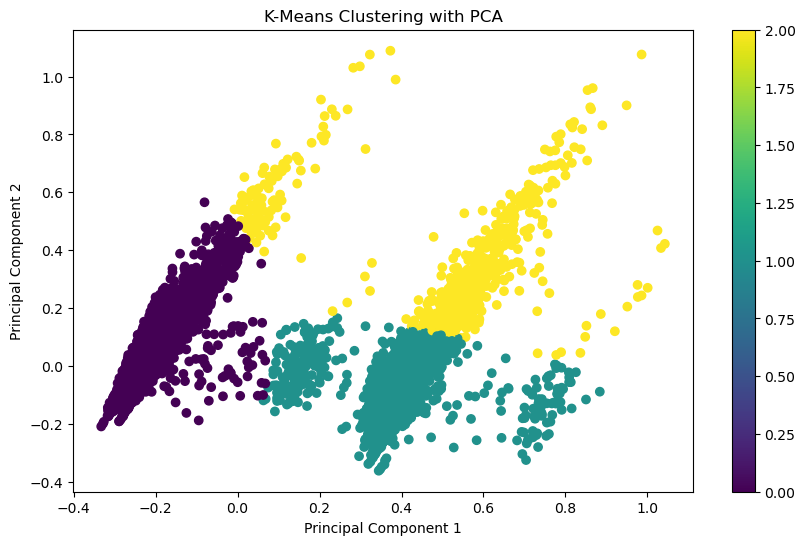

Silhouette Score: 0.5871513051885157


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset manually
file_path = "/Users/chizzycasa/Downloads/household_power_consumption.txt"
column_names = [
    "Date", "Time", "Global_active_power", "Global_reactive_power", "Voltage",
    "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]
data = pd.read_csv(file_path, sep=";", names=column_names, header=0, low_memory=False, na_values="?", dtype=str)

# Convert numeric columns to appropriate types
numeric_columns = [
    "Global_active_power", "Global_reactive_power", "Voltage",
    "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")

# Drop rows with excessive missing values
data.dropna(inplace=True)

# Extract features and target
X = data[numeric_columns]
y = data["Global_active_power"]

# Debugging initial data
print("Initial shape of features:", X.shape)
print("Initial shape of target:", y.shape)

# Adjust subset size dynamically based on available data
sample_size = min(10000, len(X), len(y))

# Subset the dataset for analysis
X = X.sample(n=sample_size, random_state=42)
y = y.sample(n=sample_size, random_state=42)

# Handle missing values
print("Missing values in features before cleaning:")
print(X.isnull().sum())
print("Missing values in target before cleaning:", y.isnull().sum())

# Fill missing values
X.fillna(X.median(), inplace=True)
y.fillna(y.median(), inplace=True)

# Validate dataset integrity
print("Features shape after cleaning:", X.shape)
print("Target shape after cleaning:", y.shape)

if X.empty or y.empty:
    raise ValueError("Dataset is empty after flexible cleaning.")

# Feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Regression Models
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Stacking Regressor
estimators = [('rf', rf), ('xgb', xgb)]
stk = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor())
stk.fit(X_train, y_train)
y_pred_stk = stk.predict(X_test)

# Metrics
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("Stacking Regressor RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_stk)))

# Clustering
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Silhouette Score
print("Silhouette Score:", silhouette_score(X_scaled, clusters))